In [2]:
import pandas as pd
import os
import mne
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from mne.stats import permutation_cluster_1samp_test
from pathlib import Path

sns.set_context("talk")

In [12]:
root = Path(Path().cwd().parent)

# Subjects ID
names = [
    "31NLI", "32CVI", "34LME", "35QSY", "36LSA", "37BMA", "38MAX", "39BDA", "40MMA",
    "41BAL", "42SPE", "44SMU", "45MJA", "46SQU", "47HMA", "50JOC", "52PFA", "53SMA",
    "55MNI", "56BCL", "57NCO", "58BAN", "59DIN", "60CAN"
    ]

In [13]:
print(f'{len(names)} participants included')

24 participants included


# Behavioral results

## Attention

Extract the average response time for each condition of the attention task.

In [14]:
# Extract behavioral results
behavior_df = pd.DataFrame([])
for subject in names:

    attention_df = pd.read_csv(Path(root, 'data/Attention/Behavior/', f'{subject}.txt'))

    for cond in ['Baseline', 'No-Think', 'Think']:

        for block in np.arange(1, 9):

            rt = attention_df['Image.RT'][(attention_df.Cond1 == cond) & 
                                          (attention_df['ListImage.Cycle'] == block)].mean()

            behavior_df = pd.concat([
                behavior_df,
                pd.DataFrame({'Subject': subject,
                               'Block' : block,
                               'Condition': cond,
                               'TR': rt}, index=[0])], 
                ignore_index=True, sort=True)

behavior_df.TR = behavior_df.TR/1000 # Convert to seconds
behavior_df['Block'] = behavior_df['Block'].astype(object)

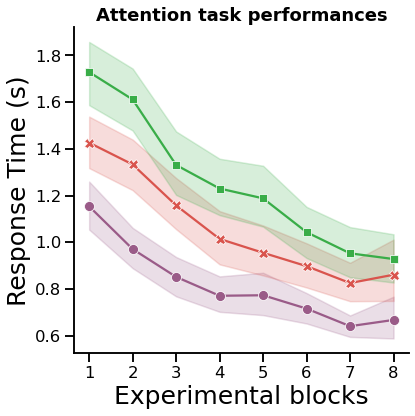

In [18]:
plt.figure(figsize=(6, 6))
sns.lineplot(data=behavior_df,
             x="Block",
             y="TR",
             hue="Condition",
             style="Condition",
             markersize=10,
             markers=True,
             legend=False,
             dashes=False,
             palette=['#9a5b88',
                      sns.xkcd_rgb["pale red"],
                      sns.xkcd_rgb["medium green"]])
plt.title('Attention task performances', fontweight="bold")
plt.xlabel('Experimental blocks', size=25)
plt.ylabel('Response Time (s)', size=25)
plt.xticks(np.arange(1, 9))
sns.despine()
plt.savefig(Path(root, 'figures', 'Figure1_Attention_RT.svg'), dpi=300, bbox_inches='tight')

RM ANOVA

In [19]:
behavior_df.rm_anova(dv='TR',
                     within=['Condition', 'Block'],
                     subject='Subject',
                     detailed=True)

/opt/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:486: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Condition,18.108473,2,46,9.054237,99.387480,2.003500e-17,1.024699e-14,0.306174,0.821521
1,Block,26.317084,7,161,3.759583,98.729158,6.120472e-55,1.143289e-28,0.390734,0.499907
2,Condition * Block,1.586131,14,322,0.113295,7.593445,8.145919e-14,1.183147e-05,0.037214,0.312246


Posthoc - Conditions

In [20]:
behavior_df.pairwise_ttests(dv='TR', 
                            within='Condition', 
                            subject='Subject',
                            padjust='bonferroni',
                            effsize='cohen')

/opt/anaconda3/lib/python3.8/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Condition,Baseline,No-Think,True,True,-10.613420,23.0,two-sided,2.457298e-10,7.371895e-10,bonferroni,4.145e+07,-1.164860
1,Condition,Baseline,Think,True,True,-13.096853,23.0,two-sided,3.784132e-12,1.135240e-11,bonferroni,2.125e+09,-1.869925
2,Condition,No-Think,Think,True,True,-5.479179,23.0,two-sided,1.432409e-05,4.297227e-05,bonferroni,1565.717,-0.743669


## Think/No-Think

Recall proportions from the TNT task.

In [21]:
recall = pd.read_csv(Path(root, 'results/Recall.txt'), sep='\t')
recall = recall.groupby(['nSub', 'Condition'], as_index=False).mean()

In [22]:
pd.DataFrame({'Rappel': recall[recall.Condition == 'No-Think'].freq.to_numpy() - recall[recall.Condition == 'Baseline'].freq.to_numpy(),
              'Subject': recall[recall.Condition == 'No-Think'].nSub.to_numpy()}).to_csv('questionnaires.txt')

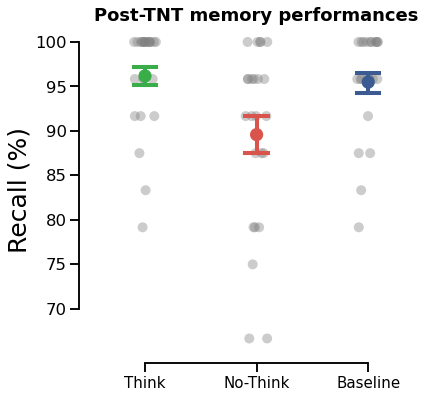

In [23]:
plt.figure(figsize=(6, 6))

sns.stripplot(data=recall, x="Condition", y="freq", 
              order=['Think', 'No-Think', 'Baseline'],
              size=10, alpha=.4, color='gray', zorder=0)

sns.pointplot(data=recall, x="Condition", y="freq", capsize=0.2,
            ci=68, legend=True, legend_out=False, dodge=2,
            order=['Think', 'No-Think', 'Baseline'],
            palette=[sns.xkcd_rgb["medium green"],
                     sns.xkcd_rgb["pale red"],
                     sns.xkcd_rgb["denim blue"]])

sns.despine(offset=10, trim=True)
plt.ylabel('Recall (%)', size=25)
plt.xlabel('')
plt.title('Post-TNT memory performances', fontweight="bold")
plt.xticks(size=15)
plt.savefig(Path(root, 'figures/Figure1_TNTRecall.svg'), dpi=300, bbox_inches='tight')

RM ANOVA

In [24]:
recall.rm_anova(dv='freq', within='Condition', subject='nSub')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,Condition,2,46,15.968153,0.000005,0.00011,0.137626,0.675722,False,0.520102,0.000753


Posthoc

In [25]:
recall.pairwise_ttests(dv='freq',
                       within='Condition',
                       subject='nSub',
                       padjust='bonferroni',
                       effsize='cohen')

/opt/anaconda3/lib/python3.8/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Condition,Baseline,No-Think,True,True,3.679358,23.0,two-sided,0.001243,0.003728,bonferroni,28.996,0.712541
1,Condition,Baseline,Think,True,True,-0.890564,23.0,two-sided,0.382385,1.000000,bonferroni,0.307,-0.119375
2,Condition,No-Think,Think,True,True,-4.978461,23.0,two-sided,0.000049,0.000148,bonferroni,512.179,-0.792025


## Decoding

In [36]:
intro_prob_df = pd.read_excel(Path(root, 'data', 'Results', 'Intprob.xlsx'), names=["1", "2", "3", "4", "5", "6", "7", "8"]).melt()

In [37]:
intro_prob_df

,variable,value
0,1,0.333333
1,1,0.363636
2,1,0.545455
3,1,0.909091
4,1,0.272727
...,...,...
179,8,0.200000
180,8,0.000000
181,8,0.750000
182,8,0.769231


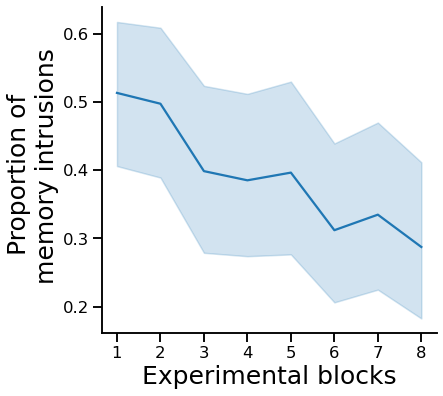

In [45]:
plt.figure(figsize=(6, 6))
sns.lineplot(data=intro_prob_df,
             x="variable",
             y="value",
             markersize=10,
             legend=False,
             dashes=False,
             palette=['#9a5b88']
            )
plt.xlabel('Experimental blocks', size=25)
plt.ylabel('Proportion of \n memory intrusions', size=25)
sns.despine()
plt.savefig(Path(root, 'figures', 'Suppl_Intrusion_prob.svg'), dpi=300, bbox_inches='tight')

# Electroencephalography

## Decoding during the attention task

Extract the average decoding scores outputed by `5_attention_decoding.py`

In [15]:
root = "D:/EEG_wd/Machine_learning/"
names_all = os.listdir(root + "TNT/1_raw")  # Subjects ID
names_all = sorted(list(set([subject[:5] for subject in names_all])))

In [16]:
scores = np.load(root + 'Attention_decoding.npy')
scores = scores[[n in names for n in names_all], :]

In [17]:
df = pd.DataFrame(scores).melt()
df['Time'] = (df.variable / 100) - 0.2

# Permutation 1 sample
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(scores - 0.5,
                                   threshold=None,
                                   n_permutations=20000,
                                   tail=0,
                                   out_type='mask',
                                   n_jobs=1)

# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.01:
        T_obs_plot[c] = T_obs[c]

Using a threshold of 2.068658
stat_fun(H1): min=-1.818702 max=13.365336
Running initial clustering
Found 16 clusters
Permuting 19999 times...
[........................................] 100.00%  |   
Computing cluster p-values
Done.


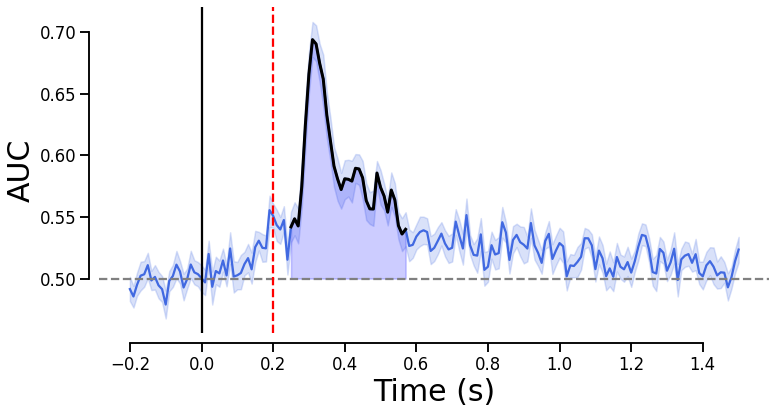

In [19]:
# Plot scores
plt.figure(figsize=(12, 6))
sns.lineplot(x="Time", y="value", 
             data=df, 
             ci=68, 
             color='royalblue')
plt.axhline(y=0.5, linestyle='--', color='gray')
plt.axvline(x=0.2, color='red', linestyle='--')
plt.axvline(x=0., color = 'k')
plt.ylabel('AUC', size=30)
plt.xlabel('Time (s)', size=30)
plt.xticks(np.arange(-0.2, 1.5, 0.2))

# plot significant time range
plt.fill_between(np.arange(-0.2, 1.51, 0.01),0.5,
                 scores.mean(0), where = ~np.isnan(T_obs_plot),
                 color='b', alpha=0.2)

mask = np.ma.masked_where(np.isnan(T_obs_plot), scores.mean(0))

plt.plot(np.arange(-0.2, 1.51, 0.01),
         mask,
         color='k',
         linewidth = 3)
sns.despine(offset=10, trim=True)
plt.savefig(cwd + '/figures/Figure2_decoding.svg', dpi=300)

In [20]:
print(f"Max decoding accuracy {scores.mean(0).argmax() * 10 - 200} after stimulus")
print(f"AUC : {scores.mean(0)[scores.mean(0).argmax()]} - std : {scores.std(0)[scores.mean(0).argmax()]}")

Max decoding accuracy 310 after stimulus
AUC : 0.69386943641644 - std : 0.06956541615234035


In [21]:
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.01:
        T_obs_plot[c] = T_obs[c]
        print(f"p value: {p_val} - Timing: {c}")

p value: 5e-05 - Timing: (slice(45, 78, None),)


## Topomap 

In [8]:
from scipy.stats import trim_mean

trim = lambda x: trim_mean(x, 0.1, axis=0)

total = []
for subject in names:

    # Import EEG data.
    attention = mne.read_epochs(root + "Attention/6_decim/" + subject + "-epo.fif")
    attention_df = pd.read_csv(root + "Attention/Behavior/" + subject + ".txt")

    baseline = (
        attention[attention_df.Cond1 == "Baseline"]
        .average(method=trim)
        .apply_baseline(baseline=(-0.2, 0))
    )
    intrusion = (
        attention[attention_df.Cond1 == "No-Think"]
        .average(method=trim)
        .apply_baseline(baseline=(-0.2, 0))
    )

    total.append(intrusion._data - baseline._data)

np.save(root + "Attention_topomap.npy", np.asarray(total))

Reading D:/EEG_wd/Machine_learning/Attention/6_decim/31NLI-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
260 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/32CVI-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
364 matching events found


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/34LME-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
347 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/35QSY-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
310 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/36LSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
334 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/37BMA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
353 matching events found


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/38MAX-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
295 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/39BDA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
347 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/40MMA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
370 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/41BAL-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
307 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/42SPE-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
313 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/44SMU-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
357 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/45MJA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
363 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/46SQU-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
353 matching events found
Applying baseline correction (mode: mean)
Not setting metadata


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/47HMA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
318 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/50JOC-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
316 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/52PFA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
357 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/53SMA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
368 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/55MNI-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
311 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/56BCL-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
349 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/57NCO-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
365 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/58BAN-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
322 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/59DIN-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
321 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

Applying baseline correction (mode: mean)
Reading D:/EEG_wd/Machine_learning/Attention/6_decim/60CAN-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1500.00 ms
        0 CTF compensation matrices available
214 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name

In [13]:
from mne.stats import permutation_t_test

fig, axs = plt.subplots(1, 7, figsize=(15, 5), facecolor="w", edgecolor="k")
fig.subplots_adjust(hspace=0.5, wspace=0.001)

data = np.load(root + "Attention_topomap.npy")

axs = axs.ravel()

for i, rg in enumerate(np.arange(48, 54, 1)):

    # Load data
    this_data = data[:, :, rg]

    n_permutations = 50000
    T0, p_values, H0 = permutation_t_test(this_data, n_permutations, n_jobs=1)

    # Extract mask and indices of active sensors in the layout
    mask = p_values[:, np.newaxis] <= 0.05

    evoked = mne.EvokedArray(T0[:, np.newaxis], attention.average().info, tmin=0.0)

    evoked.plot_topomap(
        ch_type="eeg",
        times=0,
        scalings=1,
        time_format=None,
        cmap=plt.cm.get_cmap("RdBu_r", 12),
        vmin=-6.0,
        vmax=6,
        units="t values",
        mask=mask,
        axes=axs[i],
        size=3,
        show_names=lambda x: x[4:] + " " * 20,
        time_unit="s",
        show=False,
    )

plt.savefig(cwd + "/figures/Figure2_topomaps.svg", dpi=300)
plt.clf()
plt.close()

Permuting 49999 times...
Permuting 49999 times...


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\viz\topomap.py:1809: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.subplot(1, n_fig_axes + 1, n_fig_axes + 1)


Permuting 49999 times...


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\viz\topomap.py:1809: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.subplot(1, n_fig_axes + 1, n_fig_axes + 1)


Permuting 49999 times...


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\viz\topomap.py:1809: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.subplot(1, n_fig_axes + 1, n_fig_axes + 1)


Permuting 49999 times...


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\viz\topomap.py:1809: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.subplot(1, n_fig_axes + 1, n_fig_axes + 1)


Permuting 49999 times...


C:\ProgramData\Anaconda3\envs\decoding_env\lib\site-packages\mne\viz\topomap.py:1809: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.subplot(1, n_fig_axes + 1, n_fig_axes + 1)


## Time frequency decoding

Load time-frequency decoding data.

In [22]:
# Load total
total = []
for subject in names:
    score = np.load(root + "Results/Attention_TF_decoding/" + subject + ".npy")
    total.append(score)

Cluster statistics.

In [25]:
# Plot average results
threshold = None
n_permutations = 5000
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    np.asarray(total) - 0.5, n_permutations=n_permutations, threshold=threshold, tail=0
)

# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

Using a threshold of 2.068658
stat_fun(H1): min=-3.642706 max=7.032959
Running initial clustering
Found 90 clusters
Permuting 4999 times...
[........................................] 100.00%  |   
Computing cluster p-values
Done.


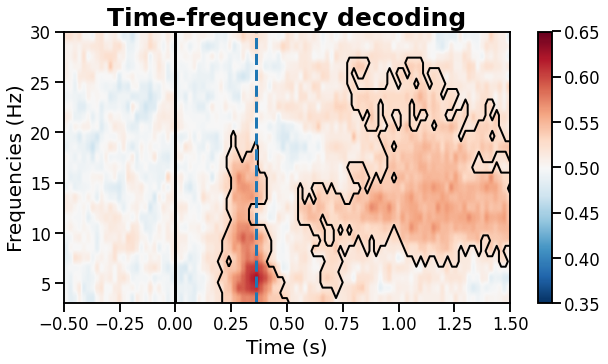

In [27]:
plt.figure(figsize=(10.0, 5.0))
max_decod = np.unravel_index(np.asarray(total).mean((0)).argmax(), [27, 101])[1]
plt.title("Time-frequency decoding", fontweight="bold", size=25)
plt.imshow(
    np.asarray(total).mean(0),
    origin="lower",
    aspect="auto",
    vmin=0.35,
    vmax=0.65,
    cmap=plt.cm.get_cmap("RdBu_r"),
    interpolation="hanning",
    extent=[-0.5, 1.5, 3, 30],
)
plt.colorbar()
plt.contour(
    ~np.isnan(T_obs_plot),
    colors=["k"],
    extent=[-0.5, 1.5, 3, 30],
    linewidths=[2],
    corner_mask=False,
    antialiased=True,
    levels=[0.5],
)
plt.axvline(x=0, color="k", linewidth=3)
plt.axvline(x=(max_decod / 50) - 0.5, linestyle="--", linewidth=3)
plt.xlabel("Time (s)", size=20)
plt.ylabel("Frequencies (Hz)", size=20)
plt.savefig(cwd + "/figures/Figure2_TF_decoding.svg", dpi=300)

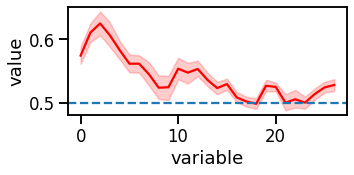

In [29]:
plt.figure(figsize=(5.0, 2.0))
df = pd.DataFrame(np.asarray(total)[:, :, max_decod]).melt()
sns.lineplot(x="variable", y="value", markers=True, data=df, ci=68, color="r")
plt.axhline(y=0.5, linestyle="--")
plt.savefig(cwd + "/figures/Figure2_TF_decoding2.svg", dpi=300)